# Setting environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

11

In [3]:
# required packages to use BERT via hub models
%%bash
pip install tqdm boto3 requests regex sentencepiece sacremoses

  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
# additional packages required (to avoid error, not mentioned in the tutorial)
!pip install huggingface_hub
!pip install tokenizers

     |████████████████████████████████| 59 kB 3.2 MB/s 
     |████████████████████████████████| 3.3 MB 5.4 MB/s 


In [ ]:
# !git clone https://github.com/Stone-bridge-NLP/BERT.git
# %cd /content/BERT

In [5]:
# download shared dataset to local disk
# [차도인] [오후 9:37] https://drive.google.com/file/d/168nKQ3EsCGfUxNNNJMYBBoWWyEmivtE-/view?usp=sharing
!gdown --id 168nKQ3EsCGfUxNNNJMYBBoWWyEmivtE-
FILENAME = 'preprocessed_train_data.csv'

Downloading...
From: https://drive.google.com/uc?id=168nKQ3EsCGfUxNNNJMYBBoWWyEmivtE-
To: /content/preprocessed_train_data.csv
100% 252M/252M [00:01<00:00, 158MB/s]


# Train model

In [6]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, accuracy_score

In [7]:
path = 'drive/My Drive/프로젝트/nlp/output/'


In [8]:
def dfRandomSample(dataframe, frac, return_loss_coef = True, verbose = True):
  Genre = dataframe['Genre'].value_counts(ascending=True).index
  max_portion = np.array(dataframe['Genre'].value_counts(ascending=True).values, dtype=np.long)
  
  portion = []
  leftover = int(len(dataframe)*frac)
  for i, v in enumerate(max_portion):
    if v > leftover//(len(Genre)-i):
      portion.append(leftover//(len(Genre)-i))
    else:
      portion.append(v)
    leftover -= portion[-1]
  
  if verbose:
    print('='*20)

  reduced = []
  for i in range(len(Genre)):
    df = dataframe[dataframe['Genre'] == Genre[i]]
    reduced.append(df.sample(portion[i],random_state=31415))
    if verbose:
      print(f'{Genre[i]}\t sample ratio\t {len(df)}:{len(reduced[-1])}')

  reduced = pd.concat(reduced).reset_index().drop(columns='index')
  if verbose:
    print(f'Total size : {len(reduced)}', end='\n\n')

  if not return_loss_coef:
    return reduced

  else:
    class_size = reduced['Genre'].value_counts()
    names=class_size.index
    ratio = np.array(class_size.values)
    return reduced, {name:coef for name, coef in zip(names,(1/ratio)*(len(reduced)/10))}

def save_checkpoint(current_epoch, model, PATH):
  torch.save({
      'current_epoch':current_epoch,
      'model':model.state_dict()
  }, PATH)

In [34]:
train_data = pd.read_csv('./'+FILENAME)
# path = 'drive/My Drive/NLP/팀플/study/output/'
# path = 'drive/My Drive/NLP/팀플/study/preprocessed_train_data.csv'
# train_dataset = pd.read_csv(path+'preprocessed_train_data.csv')

print(train_data)

        Unnamed: 0  Genre                                             Lyrics
0                0   Rock  it starts with pain followed by hate fueled by...
1                1   Rock  freedom alone again again alone patiently wait...
2                2   Rock  biting the hand that feeds you lying to the vo...
3                3   Rock  you say you know just who i am but you can t i...
4                4   Rock  my heart is beating faster can t control these...
...            ...    ...                                                ...
209268      249943    R&B  i m the best friend he s got i d give him the ...
209269      249944    Pop  bad boys blue i totally miss you i did you wro...
209270      249945    Pop  forgive me for the things that i never said to...
209271      249946  Indie  the day they found a cure for aids the day the...
209272      249947    Pop  fourth of july has come it s custom that we go...

[209273 rows x 3 columns]


In [45]:
from sklearn.model_selection import train_test_split
# Balance sampling of the DATA.
# problem here is that some genre is oversampled too much(copied 11 times)
# another problem is that this samping happens during the runtime,
# so train set and validation set is mixed up every new runtime
# ==========SOLUTION========
# First split the whole train data into 8:2 train and validation set
# to make sure they do not get mixed up
# Reduce the dataset to desired size afterwards
# 
# To prevent overcopying, start the learning with equally distributed small dataset
# Rather than overcopying, use the weighted loss
# while gradually breaking the balance by less undersampling

Genre = ['Electronic', 'Country', 'R&B', 'Jazz', 'Indie', 'Pop', 'Folk', 'Metal', 'Hip-Hop', 'Rock']
train_data = train_data[['Genre', 'Lyrics']]
train_data = train_data.drop(train_data[train_data['Genre']=='en'].index)

###############
r'''
target = train_data['Genre']
a_dataset, train_dataset = train_test_split(train_data, test_size=1, random_state=300, stratify=target)

####

print('====== validation set =======')
val_d = []
for genre in Genre:
  td = train_dataset[train_dataset['Genre'] == genre]
  val_d.append(td.sample(frac=0.2,random_state=31415))
  print(f'{genre}\tsample ratio\t {len(td)}:{len(val_d[-1])}')  
val_dataset = pd.concat(val_d)
train_dataset = train_dataset.drop(val_dataset.index)

train_dataset = train_dataset.reset_index().drop(columns='index')
val_dataset = val_dataset.reset_index().drop(columns='index')
'''

train_dataset = train_dataset[['Genre', 'Lyrics']]
train_dataset = train_dataset.drop(train_dataset[train_dataset['Genre']=='en'].index)


print('====== validation set =======')
val_d = []
for genre in Genre:
  td = train_data[train_data['Genre'] == genre]
  val_d.append(td.sample(frac=0.2,random_state=31415))
  print(f'{genre}\tsample ratio\t {len(td)}:{len(val_d[-1])}')  
val_dataset = pd.concat(val_d)

train_dataset = train_data.drop(val_dataset.index)

train_dataset = train_dataset.reset_index().drop(columns='index')
val_dataset = val_dataset.reset_index().drop(columns='index')


r'''
target2 = b_dataset['Genre']
train_dataset, val_dataset = train_test_split(b_dataset, test_size=0.2, random_state=300, stratify=target2)

for genre in Genre:
  td = train_dataset[train_dataset['Genre'] == genre]
  vd = val_dataset[val_dataset['Genre'] == genre ]
  print(f'{genre}\tsample ratio\t {len(td)}:{len(vd)}')  
'''


====== validation set =======
Electronic	sample ratio	 1831:366
Country	sample ratio	 1594:319
R&B	sample ratio	 2482:496
Jazz	sample ratio	 7026:1405
Indie	sample ratio	 6509:1302
Pop	sample ratio	 69934:13987
Folk	sample ratio	 7333:1467
Metal	sample ratio	 17283:3457
Hip-Hop	sample ratio	 2068:414
Rock	sample ratio	 93213:18643


"\ntarget2 = b_dataset['Genre']\ntrain_dataset, val_dataset = train_test_split(b_dataset, test_size=0.2, random_state=300, stratify=target2)\n\nfor genre in Genre:\n  td = train_dataset[train_dataset['Genre'] == genre]\n  vd = val_dataset[val_dataset['Genre'] == genre ]\n  print(f'{genre}\\tsample ratio\\t {len(td)}:{len(vd)}')  \n"

In [47]:
class LyricsAndGenreDataset(Dataset):
  def __init__(self, dataframe, tokenizer, num_sentence):
    self.df = dataframe
    self.tk = tokenizer
    self.num_sentence = num_sentence
    self.genre_name2id = {
        'Electronic':0, 
        'Country':1, 
        'R&B':2, 
        'Jazz':3, 
        'Indie':4, 
        'Pop':5, 
        'Folk':6, 
        'Metal':7, 
        'Hip-Hop':8, 
        'Rock':9}

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    genre = self.genre_name2id[self.df['Genre'][idx]]
    lyric = [self.df['Lyrics'][idx]]

    with torch.no_grad():
      indexed_tokens = self.tk.batch_encode_plus(
            lyric, add_special_tokens=True, padding= 'max_length', 
            max_length=2**9*self.num_sentence, truncation=True)
      

      tk_tensor = torch.tensor(indexed_tokens['input_ids']).view(-1,2**9)
      at_tensor = torch.tensor(indexed_tokens['attention_mask']).view(-1,2**9)

    return genre, tk_tensor, at_tensor



In [48]:
class TextLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, n_class, dropout):
    super(TextLSTM, self).__init__()
    self.hidden_size = hidden_size
    self.relu = nn.ReLU()
    self.lstm1 = nn.LSTM(
              input_size=input_size,
              hidden_size=hidden_size*4,
              num_layers=1,
              dropout=0,
              batch_first=True)

    self.lstm2 = nn.LSTM(
              input_size=hidden_size*4,
              hidden_size=hidden_size*2,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm3 = nn.LSTM(
              input_size=hidden_size*2,
              hidden_size=hidden_size*8,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm4 = nn.LSTM(
              input_size=hidden_size*8,
              hidden_size=hidden_size*2,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    self.lstm5 = nn.LSTM(
              input_size=hidden_size*2,
              hidden_size=hidden_size,
              num_layers=1,
              dropout=0,
              batch_first=True)
    
    
    self.dense = nn.Sequential(
        nn.ReLU(),
        nn.Linear(hidden_size, n_class),
        nn.Softmax(dim=1))


  def forward(self, X):
    outputs, (hn, cn) = self.lstm1(X)
    outputs, (hn, cn) = self.lstm2(outputs)
    outputs, (hn, cn) = self.lstm3(outputs)
    outputs, (hn, cn) = self.lstm4(outputs)
    outputs, (hn, cn) = self.lstm5(outputs)
    outputs = outputs[:,-1]
    return self.dense(outputs)

In [49]:
#### hyperparameters ####
epoch = 5
lr = 0.001
batch_size = 32
num_sentences = 1
input_size = 768
hidden_size = 128
dropout = 0
save_epoch = 1
save_path = path+'checkpoint_lstm.pth'
epoch_start = 0
dataset_fraction = 0.05

# fixed
v_dim = 768
n_genre = 10
genre_id2name = ['Electronic', 'Country', 'R&B', 'Jazz', 'Indie', 'Pop', 'Folk', 'Metal', 'Hip-Hop', 'Rock']
genre_name2id = {'Electronic':0, 'Country':1, 'R&B':2, 'Jazz':3, 'Indie':4, 'Pop':5, 'Folk':6, 'Metal':7, 'Hip-Hop':8, 'Rock':9}
device = torch.device('cuda') if (torch.cuda.is_available())else torch.device('cpu')

In [50]:
# load pretrained gpt2 tokenizer and bare gpt2 model
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'gpt2')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
gpt2_embedding = torch.hub.load('huggingface/pytorch-transformers', 'model', 'gpt2').to(device)
print(len(tokenizer))
gpt2_embedding.resize_token_embeddings(len(tokenizer))

# undersample the dataset to desired size
reduced_train_dset,tr_loss_coef = dfRandomSample(train_dataset,dataset_fraction)
print(tr_loss_coef)
reduced_val_dset, vl_loss_coef = dfRandomSample(val_dataset,dataset_fraction)
print(vl_loss_coef)

# declare torch.utils.data.Dataset
train_set = LyricsAndGenreDataset(reduced_train_dset,tokenizer,num_sentences)
val_set = LyricsAndGenreDataset(reduced_val_dset,tokenizer,num_sentences)

# train and validation data loader
train_loader = DataLoader(train_set,batch_size=batch_size, shuffle=True, 
                          num_workers=0, drop_last=True)
val_loader = DataLoader(val_set,batch_size=batch_size, shuffle=True, 
                          num_workers=0, drop_last=True)

lstm_classifier = TextLSTM(input_size, hidden_size, n_genre, dropout).to(device)

# load model if possible
try:
  cp = torch.load(save_path)
  epoch_start= cp['current_epoch']+1
  lstm_classifier.load_state_dict(cp['model'])
  print(f'\nsavefile from {save_path} loaded')
except FileNotFoundError:
  print('\nno savefile to load')

print(lstm_classifier)
print(sum(p.numel() for p in lstm_classifier.parameters() if p.requires_grad))
loss_func = nn.CrossEntropyLoss(reduction='none')
params = list(lstm_classifier.parameters())
optimizer = optim.Adam(params, lr=lr)

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master


50258
Country	 sample ratio	 1275:837
Electronic	 sample ratio	 1465:837
Hip-Hop	 sample ratio	 1654:837
R&B	 sample ratio	 1986:837
Indie	 sample ratio	 5207:837
Jazz	 sample ratio	 5621:837
Folk	 sample ratio	 5866:837
Metal	 sample ratio	 13826:837
Pop	 sample ratio	 55947:837
Rock	 sample ratio	 74570:837
Total size : 8370

{'Jazz': 0.9999999999999999, 'Hip-Hop': 0.9999999999999999, 'Rock': 0.9999999999999999, 'Indie': 0.9999999999999999, 'Country': 0.9999999999999999, 'Pop': 0.9999999999999999, 'Folk': 0.9999999999999999, 'Metal': 0.9999999999999999, 'Electronic': 0.9999999999999999, 'R&B': 0.9999999999999999}
Country	 sample ratio	 319:209
Electronic	 sample ratio	 366:209
Hip-Hop	 sample ratio	 414:209
R&B	 sample ratio	 496:209
Indie	 sample ratio	 1302:209
Jazz	 sample ratio	 1405:209
Folk	 sample ratio	 1467:209
Metal	 sample ratio	 3457:209
Pop	 sample ratio	 13987:210
Rock	 sample ratio	 18643:210
Total size : 2092

{'Rock': 0.9961904761904762, 'Pop': 0.9961904761904762, 'J

VAL: [4/5] batch [64/65]       loss 2.301257557645287	 acc 0.25	no savefile


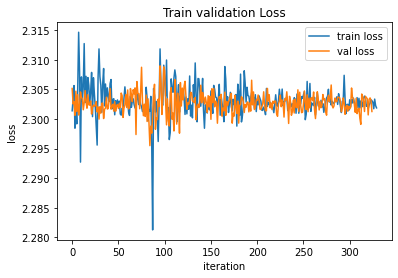

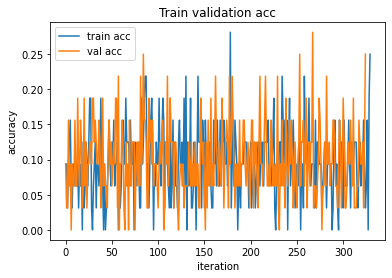

In [51]:
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

lstm_classifier.train()

for e in range(epoch_start, epoch, 1):
  for b,batch in enumerate(train_loader):
    label_batch = batch[0].to(device)
    tk_batch = batch[1].to(device).view(-1,2**9)
    at_batch = batch[2].to(device).view(-1,2**9)
    sg_batch = torch.zeros_like(at_batch)

    loss_coef = torch.tensor(
        [tr_loss_coef[genre_id2name[i]] for i in batch[0]]).to(device)

    with torch.no_grad():
      embedding = gpt2_embedding(tk_batch,token_type_ids=sg_batch,attention_mask=at_batch,)

    embedded_tokens = embedding[0].detach().view(batch_size,2**9*num_sentences,-1)

    output = lstm_classifier.forward(embedded_tokens)

    optimizer.zero_grad()
    loss = torch.mean(loss_coef*loss_func(output, label_batch))
    loss.backward()
    optimizer.step()
    
    if b%4 == 0:
      train_loss_list.append(float(loss.detach().cpu().data))
      pred = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()
      acc = np.mean(pred == label_batch.detach().cpu().numpy().flatten())
      train_acc_list.append(float(acc))

      print(f'\rTRAIN: epoch [{e}/{epoch}] batch [{b}/{len(train_loader)}]\
       loss {train_loss_list[-1]}\t acc {train_acc_list[-1]}', end='\t')

  for b,batch in enumerate(val_loader):
    label_batch = batch[0].to(device)
    tk_batch = batch[1].to(device).view(-1,2**9)
    sg_batch = torch.zeros_like(tk_batch)
    at_batch = batch[2].to(device).view(-1,2**9)

    loss_coef = torch.tensor(
        [vl_loss_coef[genre_id2name[i]] for i in batch[0]]).to(device)

    with torch.no_grad():
      embedding = gpt2_embedding(
          tk_batch,
          token_type_ids= sg_batch,
          attention_mask=at_batch)

      embedded_tokens = embedding[0].view(batch_size,2**9*num_sentences,-1)

      output = lstm_classifier.forward(embedded_tokens)

      optimizer.zero_grad()
      loss = torch.mean(loss_coef*loss_func(output, label_batch))
    

    val_loss_list.append(float(loss.detach().cpu().data))
    pred = np.argmax(output.detach().cpu().numpy(),axis=1).flatten()
    acc = np.mean(pred == label_batch.detach().cpu().numpy().flatten())
    val_acc_list.append(float(acc))

    print(f'\rVAL: [{e}/{epoch}] batch [{b}/{len(val_loader)}]\
       loss {val_loss_list[-1]}\t acc {val_acc_list[-1]}', end='\t')

  if e%save_epoch == 0:
    save_checkpoint(e,lstm_classifier,save_path)



import matplotlib.pyplot as plt

try:
  tll = np.load(path+'train_loss_list.npy')
  vll = np.load(path+'val_loss_list.npy')
  tal = np.load(path+'train_acc_list.npy')
  val = np.load(path+'val_acc_list.npy')

  tll = tll.tolist() + train_loss_list
  vll = vll.tolist() + val_loss_list
  tal = tal.tolist() + train_acc_list
  val = val.tolist() + val_acc_list
except FileNotFoundError:

  print('no savefile')
  tll = train_loss_list
  vll = val_loss_list
  tal = train_acc_list
  val = val_acc_list




plt.title('Train validation Loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(tll, label='train loss')
plt.plot(vll, label='val loss')
plt.legend()
plt.show()


plt.title('Train validation acc')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.plot(tal, label='train acc')
plt.plot(val, label='val acc')
plt.legend()
plt.show()


np.save(path+'train_loss_list.npy',tll)
np.save(path+'val_loss_list.npy',vll)
np.save(path+'train_acc_list.npy',tal)
np.save(path+'val_acc_list.npy',val)

In [ ]:
## 위에 합쳐버림
## 안 돌려도 됨

r'''
import matplotlib.pyplot as plt

try:
  tll = np.load(path+'train_loss_list.npy')
  vll = np.load(path+'val_loss_list.npy')
  tal = np.load(path+'train_acc_list.npy')
  val = np.load(path+'val_acc_list.npy')

  tll = tll.tolist() + train_loss_list
  vll = vll.tolist() + val_loss_list
  tal = tal.tolist() + train_acc_list
  val = val.tolist() + val_acc_list
except FileNotFoundError:

  print('no savefile')
  tll = train_loss_list
  vll = val_loss_list
  tal = train_acc_list
  val = val_acc_list
'''

no savefile


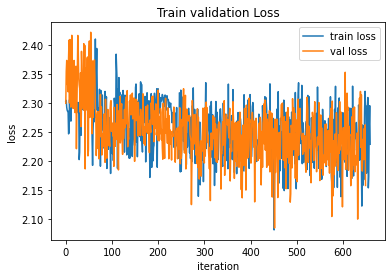

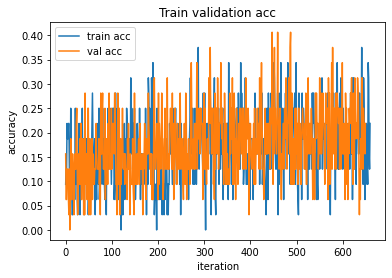

<Figure size 432x288 with 0 Axes>

In [ ]:
## 위와 합침

r'''
plt.title('Train validation Loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(tll, label='train loss')
plt.plot(vll, label='val loss')
plt.legend()
plt.show()
plt.savefig(path+'train-validation loss.png')


plt.title('Train validation acc')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.plot(tal, label='train acc')
plt.plot(val, label='val acc')
plt.legend()
plt.show()
plt.savefig(path+'train-validation acc.png')
'''

In [ ]:
'''
np.save(path+'train_loss_list.npy',tll)
np.save(path+'val_loss_list.npy',vll)
np.save(path+'train_acc_list.npy',tal)
np.save(path+'val_acc_list.npy',val)
'''

In [23]:
# [차도인] [오후 9:37] https://drive.google.com/file/d/168qGvi5w4Wwgu5QTpPoLkZzoJNAgyc6b/view?usp=sharing
!gdown --id 168qGvi5w4Wwgu5QTpPoLkZzoJNAgyc6b
TESTFILENAME = 'preprocessed_test_data.csv'

Downloading...
From: https://drive.google.com/uc?id=168qGvi5w4Wwgu5QTpPoLkZzoJNAgyc6b
To: /content/preprocessed_test_data.csv
100% 9.63M/9.63M [00:00<00:00, 78.3MB/s]


In [ ]:
batch_size = 1

test_dataset = pd.read_csv('./'+TESTFILENAME)
print(test_dataset['Genre'].value_counts())
print(len(test_dataset))

# declare torch.utils.data.Dataset
test_set = LyricsAndGenreDataset(test_dataset,tokenizer,num_sentences)

# test data loader
test_loader = DataLoader(test_set,batch_size=batch_size, shuffle=True, 
                          num_workers=0, drop_last=True)



Rock          1410
Pop           1110
Hip-Hop        960
Metal          810
Country        810
Jazz           659
Electronic     659
Indie          510
R&B            509
Folk           495
Name: Genre, dtype: int64
7932


In [ ]:
## jude
## test case
## for f1-score

real_labels = []
prediction_labels = []

lstm_classifier.eval()
c_mat = np.zeros((10,4)) # confusion matrix. TP, FP, FN, TN
f1 = []
with torch.no_grad():
  for b, batch in enumerate(test_loader):
    label_batch = batch[0].to(device)
    real_labels += label_batch.tolist()
    tk_batch = batch[1].to(device).view(-1,2**9)
    sg_batch = torch.zeros_like(tk_batch)
    at_batch = batch[2].to(device).view(-1,2**9)

    embedding = gpt2_embedding(
        tk_batch, 
        token_type_ids= sg_batch,
        attention_mask=at_batch)

    embedded_tokens = embedding[0].view(batch_size,2**9*num_sentences,-1)

    output = lstm_classifier.forward(embedded_tokens)

    ###
    o = output.detach().cpu().numpy()
    # print(np.argmax(o,axis=1))
    
    pred = torch.argmax(output,axis=1)
    prediction_labels += pred.tolist()

    acc = float(torch.sum(pred == label_batch))/batch_size
    print(f'\rbatch [{b}/{len(test_loader)}] acc: {acc}', end='\t')

    for i in range(10):
      c_mat[i,0] += int(torch.sum((pred == i)*(label_batch == i)))
      c_mat[i,1] += int(torch.sum((pred == i)*(label_batch != i)))
      c_mat[i,2] += int(torch.sum((pred != i)*(label_batch == i)))
      c_mat[i,3] += int(torch.sum((pred != i)*(label_batch != i)))



#############


batch [7931/7932] acc: 0.0	

In [ ]:
## epoch 10

evaluation_report = classification_report(real_labels, prediction_labels, labels=list(genre_name2id.values()), target_names=list(genre_name2id.keys()))
print(evaluation_report)

              precision    recall  f1-score   support

  Electronic       0.00      0.00      0.00       659
     Country       0.18      0.01      0.02       810
         R&B       0.09      0.47      0.15       509
        Jazz       0.13      0.17      0.15       659
       Indie       0.00      0.00      0.00       510
         Pop       0.00      0.00      0.00      1110
        Folk       0.08      0.48      0.14       495
       Metal       0.00      0.00      0.00       810
     Hip-Hop       0.53      0.79      0.63       960
        Rock       0.00      0.00      0.00      1410

    accuracy                           0.17      7932
   macro avg       0.10      0.19      0.11      7932
weighted avg       0.10      0.17      0.11      7932



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
## epoch 10

print([genre_id2name[i] for i in range(10)])
print(c_mat)

['Electronic', 'Country', 'R&B', 'Jazz', 'Indie', 'Pop', 'Folk', 'Metal', 'Hip-Hop', 'Rock']
[[0.000e+00 0.000e+00 6.590e+02 7.273e+03]
 [9.000e+00 4.000e+01 8.010e+02 7.082e+03]
 [2.370e+02 2.503e+03 2.720e+02 4.920e+03]
 [1.110e+02 7.610e+02 5.480e+02 6.512e+03]
 [0.000e+00 3.000e+00 5.100e+02 7.419e+03]
 [0.000e+00 0.000e+00 1.110e+03 6.822e+03]
 [2.370e+02 2.612e+03 2.580e+02 4.825e+03]
 [0.000e+00 0.000e+00 8.100e+02 7.122e+03]
 [7.540e+02 6.650e+02 2.060e+02 6.307e+03]
 [0.000e+00 0.000e+00 1.410e+03 6.522e+03]]


In [ ]:
## epoch 5

precision = [c[0]/(c[0]+c[1]) if c[0] != 0 else 0 for c in c_mat]
recall = [c[0]/(c[0]+c[2]) if c[0] != 0 else 0 for c in c_mat]

f1 = [2*p*r/(p+r) if p*r != 0 else 0 for p, r in zip(precision,recall)]

print('f1 score each class')
print(f1)
print('overall f1 score')
print(np.mean(f1))


f1 score each class
[0, 0.14956736711990112, 0.037914691943127965, 0, 0, 0, 0.1386416861826698, 0, 0.5749636098981078, 0.21152494729444837]
overall f1 score
0.1112612302438255


In [ ]:
## epoch 5
print([genre_id2name[i] for i in range(10)])
print(c_mat)


['Electronic', 'Country', 'R&B', 'Jazz', 'Indie', 'Pop', 'Folk', 'Metal', 'Hip-Hop', 'Rock']
[[0.000e+00 0.000e+00 6.590e+02 7.273e+03]
 [1.210e+02 6.870e+02 6.890e+02 6.435e+03]
 [1.200e+01 1.120e+02 4.970e+02 7.311e+03]
 [0.000e+00 1.000e+00 6.590e+02 7.272e+03]
 [0.000e+00 0.000e+00 5.100e+02 7.422e+03]
 [0.000e+00 0.000e+00 1.110e+03 6.822e+03]
 [2.960e+02 3.479e+03 1.990e+02 3.958e+03]
 [0.000e+00 0.000e+00 8.100e+02 7.122e+03]
 [7.900e+02 9.980e+02 1.700e+02 5.974e+03]
 [3.010e+02 1.135e+03 1.109e+03 5.387e+03]]


In [ ]:
## epoch 5

test_dataset = pd.read_csv('./'+TESTFILENAME)

print(test_dataset['Genre'].value_counts())
P = [n/len(test_dataset) for n in test_dataset['Genre'].value_counts()]
print(P)
f1_score = {n:2*p*0.5/(0.5+p) for n, p in zip(test_dataset['Genre'].value_counts().index, P)}
print(f1_score)
print(sum(f1_score.values())/10)
# print(np.mean(f1_score.values()))

Rock          1410
Pop           1110
Hip-Hop        960
Country        810
Metal          810
Jazz           659
Electronic     659
Indie          510
R&B            509
Folk           495
Name: Genre, dtype: int64
[0.1777609682299546, 0.13993948562783662, 0.12102874432677761, 0.1021180030257186, 0.1021180030257186, 0.08308119011598589, 0.08308119011598589, 0.06429652042360061, 0.06417044881492688, 0.062405446293494704]
{'Rock': 0.2622767857142857, 'Pop': 0.2186761229314421, 'Hip-Hop': 0.194884287454324, 'Country': 0.16959798994974873, 'Metal': 0.16959798994974873, 'Jazz': 0.14248648648648649, 'Electronic': 0.14248648648648649, 'Indie': 0.11394101876675605, 'R&B': 0.11374301675977655, 'Folk': 0.1109616677874916}
0.16386518522865465
